# CMSC 657 Final Project
## Scalibility and performance between differing implementations of the quantum division algorithm
### Addison Hanrattie

At the heart of computer science and nearly any problem one could approach is logic and arithmetic. Much effort has been put into ensuring that these algorithms are as efficient as they can be. Classically this has led to the creation of everything from the carry look-ahead adder circuit to new forms of math for cryptography schemes and advances in GPU and TPU technologies for solving as many problems per second as one can. The quantum frontier presents a new challenge as not only must one keep in mind all the ideas and lessons of classical numerical analysis but also keep in mind and deal with all the problems that arise from quantum information processing. 

While the “weirdness” of quantum mechanics can be a challenge to deal with its unique properties can permit new algorithms which would not be feasible otherwise. The most well-known arithmetic algorithm here is likely the draper adder [1]. This algorithm leverages the quantum fourier transform to reduce the number of qubits required to perform an addition between two numbers. Furthermore, it allows for adding classical constants to a number for no cost at all. This algorithm was a gr improvement over the previously used classically inspired ripple carry adder (better quantum ripple carry adders have since been developed [2]). There is now a large number of quantum algorithms available for doing different forms of arithmetic and which range in the specific type of niche they serve. These niches vary quite widely including those which focus on execution speed, specific hardware gate sets, robustness to errors, and reductions in required ancillas. 

Qiskit is a very popular quantum programming language which can generate code that can both be simulated or run on an actual quantum computer. Contained within the package in a library of common arithmetic functions however no implementations exist for performing integer division. Therefore for my project I will focus on implementing this algorithm via the library and ideally merging my code into the actual library. Arithmetic operations while not the most celebrated part of quantum computing are essential for building end to end quantum applications which chain together different algorithms to create ever more complex ones capable of carrying out nuanced calculations. Therefore I estimate there will be a large benefit to implementing these algorithms so that other developers can use them.

[1] https://arxiv.org/pdf/quant-ph/0008033

[2] https://arxiv.org/abs/quant-ph/0410184

## Thapliyal Algorithm

In their 2018 paper "Quantum Circuit Designs of Integer Division Optimizing T-count and T-depth" Thapliyal et al describe a optimized version of the quantum integer divider for two positive n bit twos complement integers. They implement their design under the hood using the restoring division algorithm which for the adders uses a quantum ripple carry adder. Below I have written code which verifies that for every possible input of a N=5 division the algorithm is correct. I would imagine my computer would really begin struggling to run anything larger than this as the cell takes over 2 minutes to run at this point. A image showing the circuit for a N=3 division is included below as well. A few neat parts of this algorithm which isn't found in any which would claim to be better is that as of now it has one of the best optimized t-counts and t-depths (runs fast and without too many errors) while outputting the remainder and quotient and not requiring any garbage qubits and the minimum number of ancillas and finally it is reversible (can be used with whatever algorithms may need reversibility ie grovers).

PS I screwed up the way my jobs saved and I am still waiting for IBM to get back to me with the job results. I will update with them once I get them. 

In [1]:
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from long_division_divider import long_division_divider, other_divider
import matplotlib.pyplot as plt
import mthree as m3

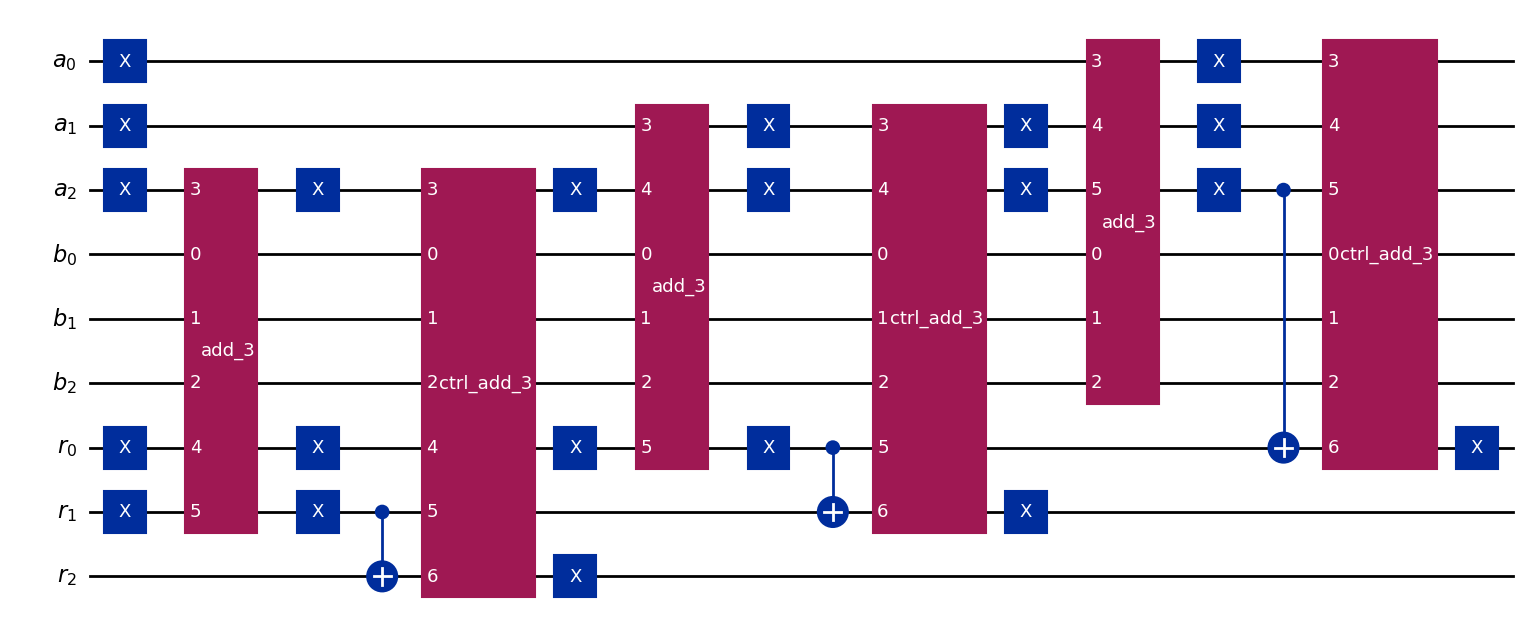

In [116]:
div_circuit = long_division_divider(5)
ld3 = long_division_divider(3)
ld3.draw('mpl')

In [3]:
errs = 0
for i in range(2**4):
    for j in range(2**4):
        if j == 0:
            continue
        state = Statevector.from_label(
            f'00000' + f'{j:05b}' + f'{i:05b}'
        )
        state = state.evolve(div_circuit)
        remainder = state.probabilities([0,1,2,3,4]).argmax()
        quotient = state.probabilities([10,11,12,13,14]).argmax()
        if i % j != remainder or i // j != quotient:
            print(f'Error: {i:05b} % {j:05b} = {i} % {j}')
            errs += 1

print(f'Errors: {errs}')

Errors: 0


### Real World Performance

Here is an example of running the algorithm on a real quantum computer. As will be shown the algorithm runs without issues. Furthermore one will see the algorithm does not run perfectly but does reasonably well. We would normally expect to always get a quotient of 2 and remainder of 1 while the divisor of 2 doesn't change.

In [94]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Login to the IBM Quantum service
service = QiskitRuntimeService()
# Choose the backend and get its sampler
backend = service.least_busy(operational=True, simulator=False)
sampler = Sampler(backend)
sampler.options.default_shots = 1000
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
backend

<IBMBackend('ibm_brisbane')>

In [117]:
# Setup a division problem with some quantum components how about 3 / 2

circuit = QuantumCircuit(9, 9)
circuit.x(0)
circuit.x(1)
circuit.x(4)
circuit.append(ld3, range(9))

circuit.measure(range(9), range(9))

isa_circuit = pm.run(circuit)

In [118]:
sampler.options.default_shots = 10000
job = sampler.run([isa_circuit])
sampler.options.default_shots = 1000
print(job.usage_estimation)

{'quantum_seconds': 6.754787889739086}


Mode of divisor 4
Mode of remainder 1 001
Mode of quotient 0


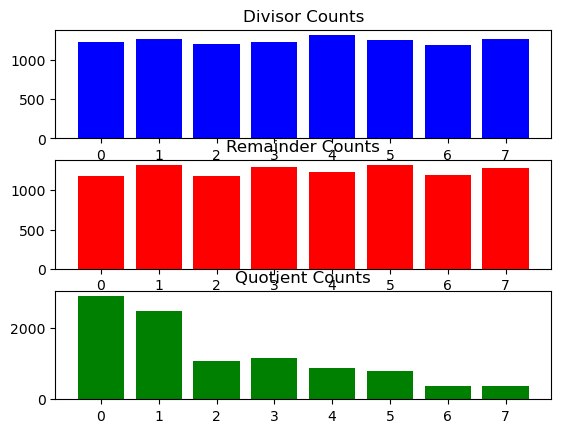

In [119]:
result = job.result()[0]
arr = result.data.c

# M3 Error correction (Uses up too much of my free compute time)
# mappings = m3.utils.final_measurement_mapping(isa_circuit)
# mit = m3.M3Mitigation(backend)
# mit.cals_from_system(mappings)
# quasis = mit.apply_correction(arr, mappings)

divisor_counts = arr.slice_bits(range(3,6)).get_int_counts()
remainder_counts = arr.slice_bits(range(0,3)).get_int_counts()
quotient_counts = arr.slice_bits(range(6,9)).get_int_counts()
# plot the counts with chart tile "counts of values"
fig, ax = plt.subplots(3)
ax[0].bar(divisor_counts.keys(), divisor_counts.values(), color='b')
ax[0].set_title('Divisor Counts')
ax[1].bar(remainder_counts.keys(), remainder_counts.values(), color='r')
ax[1].set_title('Remainder Counts')
ax[2].bar(quotient_counts.keys(), quotient_counts.values(), color='g')
ax[2].set_title('Quotient Counts')

# mode
print("Mode of divisor", max(divisor_counts, key=divisor_counts.get))
print("Mode of remainder", max(remainder_counts, key=remainder_counts.get), f'{max(remainder_counts, key=remainder_counts.get):03b}')
print("Mode of quotient", max(quotient_counts, key=quotient_counts.get))

As is shown in these results a lot of noise acrews while running the algorithm without error correction. For the divisor which isn't even touched during the algorithm (on a standard implementation) the actual value of 2 is just as likely as any of the other values. This is likely due to the fact that in reality the divisor is touched during execution due to how cnot gates are implemented and then errors in that way that gates is implemented accrue ultimately making any result as likely as any other. 
For the remainder we can see that the true value does lightly show through since all the odd values are slightly more likely than the even values. However the noise is still quite high. 

Finally for the quotient we can see the best performance of the algorithm (though still not very good). The quotient of 1 is the second most likely value after zero and I would imagine this is likely due to decoherence and the qubit resetting to the ground state due to the length of the algorithm. Nevertheless there is a sharp drop for all other values of the quotient and this is likely due to the fact that those values are measured earlier in the algorithm and may also have more accurately implemented gates which affect them. 

### Scalability

Next we can see how quickly the runtime of the algorithm grows as the number of qubits in the division grows. This is important as it will help us understand how the algorithm will scale as we increase the number of bits in the division. Specifically it will be seen that the growth is quadratic and this should make sense as the algorithm has a O(N^2) T-depth.

In [120]:
def ld_one_one_divider(n):
    # For a circuit that divides n bits by n bits calculate 1 / 1
    circuit = QuantumCircuit(n * 3, n*3)
    circuit.x(0)
    circuit.x(n)
    
    circuit.append(long_division_divider(n), range(n * 3))
    
    circuit.measure(range(n * 3), range(n * 3))
    
    return circuit

In [ ]:
job4 = sampler.run([pm.run(ld_one_one_divider(4))])
job8 = sampler.run([pm.run(ld_one_one_divider(8))])
job16 = sampler.run([pm.run(ld_one_one_divider(16))])
job32 = sampler.run([pm.run(ld_one_one_divider(32))])

# How much the runtimes grow
print("job4 time", job4.usage_estimation)
print("job8 time", job8.usage_estimation)
print("job16 time", job16.usage_estimation)
print("job32 time", job32.usage_estimation)

job4 time {'quantum_seconds': 3.7778541290247833}
job8 time {'quantum_seconds': 5.130763931437228}
job16 time {'quantum_seconds': 11.044302040375616}
job32 time {'quantum_seconds': 19.028681437803424}


As can be seen the actual time required to run the algorithm is actually roughly linear despite the t-count of the algorithm being quadratic. This is likely due to a few reasons having to do with the way the quantum computer is implemented. First of all the basis gates of the Eagle R3 qpu's which I am running on for free on the ibm cloud include: ECR, ID, RZ, SX, X. These gates are obviously not the t-gate and thus despite the complexity of the circuit's t-depth being quadratic the actual time required to run the algorithm is linear as whatever in the gate set dominates the time must only be run linearly. 

In [123]:
for i in [4,8,16,32]:
    print(i, "depth is", ld_one_one_divider(i).decompose().depth(), "count is", sum(ld_one_one_divider(i).decompose().count_ops().values()))
for i in [4,8,16,32]:
    isa_circ = pm.run(ld_one_one_divider(i))
    print(i, "compiled depth is", isa_circ.depth(), "count is", sum(isa_circ.count_ops().values()))

4 depth is 22 count is 62
8 depth is 42 count is 186
16 depth is 82 count is 626
32 depth is 162 count is 2274
4 compiled depth is 3067 count is 6101
8 compiled depth is 14106 count is 28849
16 compiled depth is 64870 count is 123917
32 compiled depth is 273001 count is 530110


While the total circuit gate-depth is linear for standard gates. When actually implemented on a quantum computer we get a quadratic growth in the number of gates required to run the algorithm. This is likely due to the fact that the gates in the basis set are not the same as the gates in the algorithm and thus the algorithm must be decomposed into basis gates. Then due to the structure of the algorithm and how these gates are decomposed we get a quadratic growth in the number of gates required to run the algorithm. However again as I have said it would seem that whatever gate in the set dominates the time required must only be run linearly.

In [128]:
for i in [4,8,16,32]:
    isa_circ = pm.run(ld_one_one_divider(i))
    print(i, "rz-depth", isa_circ.depth(lambda gate: gate[0].name == 'rz'), "sx-gate depth", isa_circ.depth(lambda gate: gate[0].name == 'sx'), "ecr-depth", isa_circ.depth(lambda gate: gate[0].name == 'ecr'), "x-depth", isa_circ.depth(lambda gate: gate[0].name == 'x'))

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_21207/3909143227.py:3: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print(i, "rz-depth", isa_circ.depth(lambda gate: gate[0].name == 'rz'), "sx-gate depth", isa_circ.depth(lambda gate: gate[0].name == 'sx'), "ecr-depth", isa_circ.depth(lambda gate: gate[0].name == 'ecr'), "x-depth", isa_circ.depth(lambda gate: gate[0].name == 'x'))


4 rz-depth 1478 sx-gate depth 908 ecr-depth 787 x-depth 56
8 rz-depth 6970 sx-gate depth 4304 ecr-depth 3471 x-depth 233
16 rz-depth 30412 sx-gate depth 18498 ecr-depth 15437 x-depth 1034
32 rz-depth 130297 sx-gate depth 79003 ecr-depth 65589 x-depth 4684


4 bit
Mode of divisor 11
Mode of remainder 1 001
Mode of quotient 11
8 bit
Mode of divisor 119
Mode of remainder 229 11100101
Mode of quotient 112
16 bit
Mode of divisor 56800
Mode of remainder 54787 1101011000000011
Mode of quotient 50749
32 bit
Mode of divisor 2902079627
Mode of remainder 3781203137 11100001011000001001010011000001
Mode of quotient 851916558


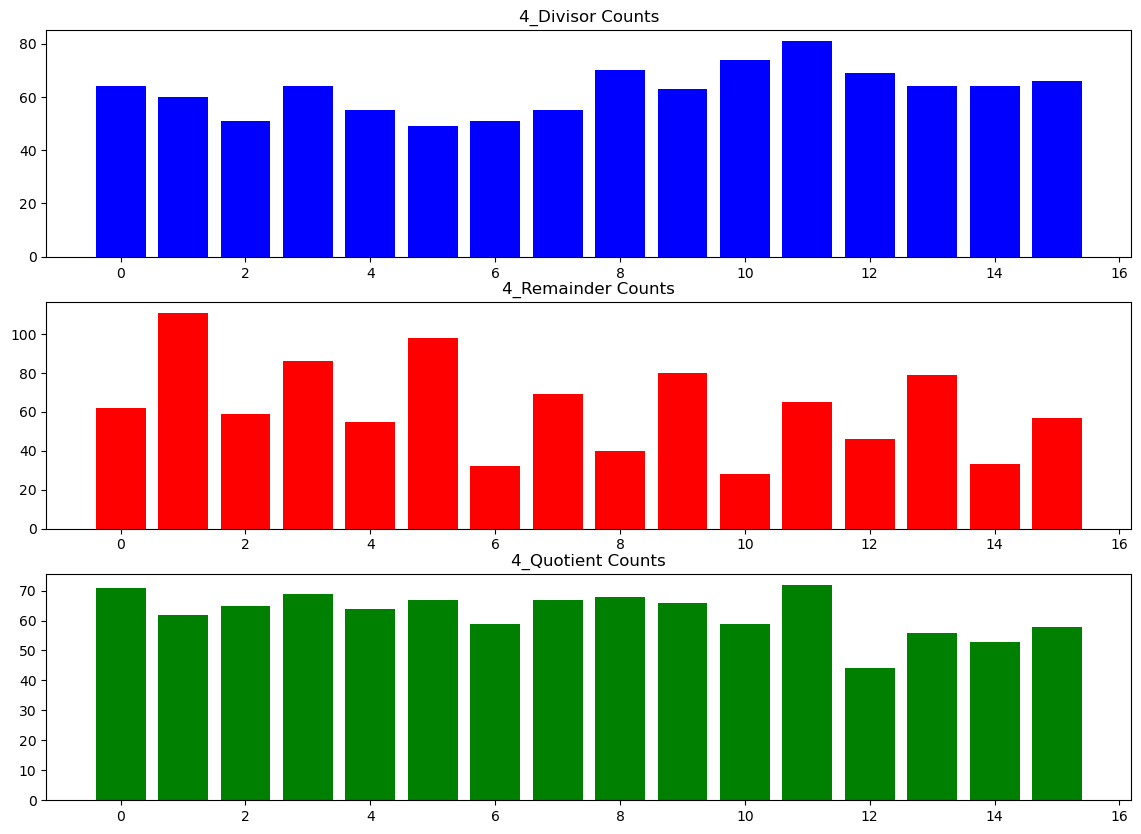

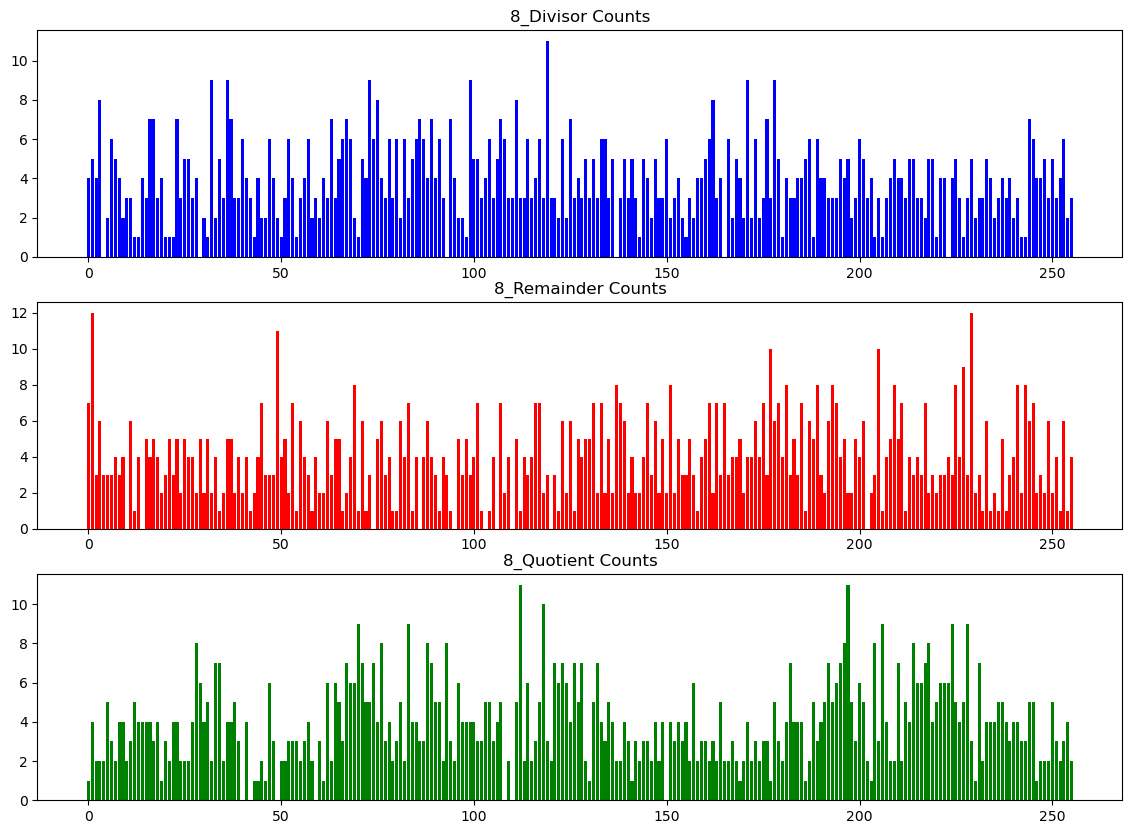

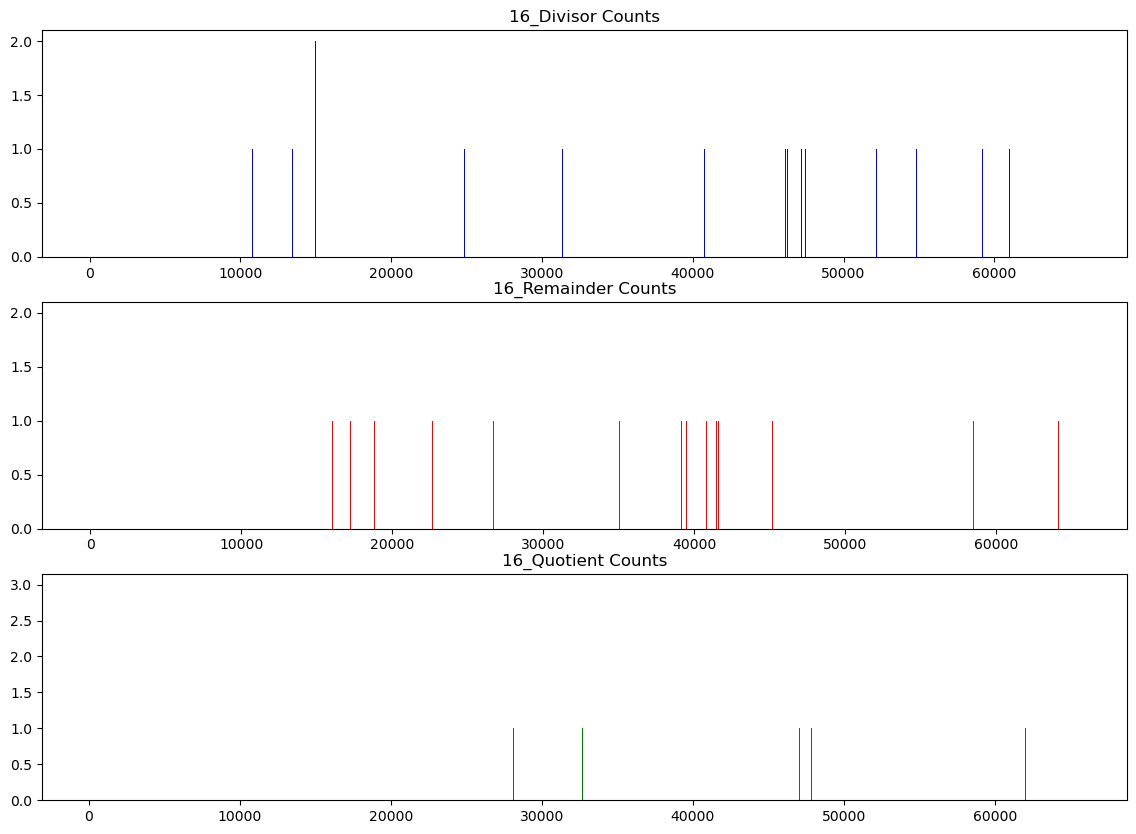

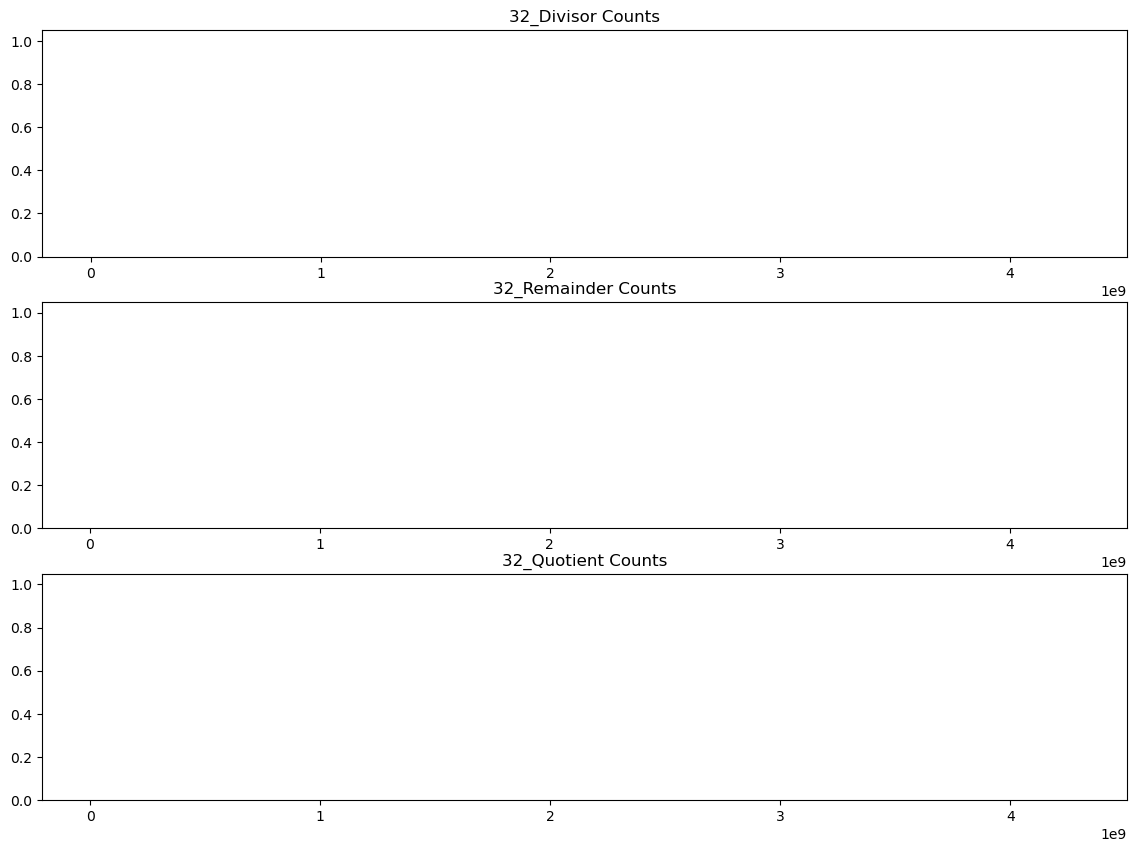

In [130]:
for i in [4,8,16,32]:
    if i == 0:
        result = job4.result()[0]
    elif i == 1:
        result = job8.result()[0]
    elif i == 2:
        result = job16.result()[0]
    else:
        result = job32.result()[0]
    print(f"{i} bit")
    arr = result.data.c

    remainder_counts = arr.slice_bits(range(0,i)).get_int_counts()
    divisor_counts = arr.slice_bits(range(i,2*i)).get_int_counts()
    quotient_counts = arr.slice_bits(range(2*i,3*i)).get_int_counts()
    # plot the counts with chart tile "counts of values"
    fig, ax = plt.subplots(3, figsize=(14,10))
    ax[0].bar(divisor_counts.keys(), divisor_counts.values(), color='b')
    ax[0].set_title(f'{i}_Divisor Counts')
    ax[1].bar(remainder_counts.keys(), remainder_counts.values(), color='r')
    ax[1].set_title(f'{i}_Remainder Counts')
    ax[2].bar(quotient_counts.keys(), quotient_counts.values(), color='g')
    ax[2].set_title(f'{i}_Quotient Counts')

    # mode
    print("Mode of divisor", max(divisor_counts, key=divisor_counts.get))
    print("Mode of remainder", max(remainder_counts, key=remainder_counts.get), f'{max(remainder_counts, key=remainder_counts.get):03b}')
    print("Mode of quotient", max(quotient_counts, key=quotient_counts.get))

As can be seen noise dominates the results for pretty much every value of N I cover here. This makes sense as the time required to run the algorithm is approaching an order of milliseconds by N=32 and the t1 and t2 rate for ibm_brisbane where I am running this is 233.8us and 131.7us respectively. In fact by the N=32 qubit length there isn't a single bitstring which has an occurrence more than once. 

### The Draper Adder

The exact adder used in the Thapliyal algorithm is unimportant so we can substitute another one in their. Of particular interest may be the draper adder due to its fairly non-classical nature. The adder has a much worse performance due to the number of small phase changes that must be made. Thus we can re-run the pervious problem again to see that since the circuit isn't as efficient there is more noise in the results. 

In [132]:
# Setup a division problem how about 3 / 2

circuit = QuantumCircuit(9, 9)
circuit.x(0)
circuit.x(1)
circuit.x(4)
circuit.append(long_division_divider(3, True), range(9))

circuit.measure(range(9), range(9))

draper_isa_circuit = pm.run(circuit)

In [133]:
sampler.options.default_shots = 10000
draper_job = sampler.run([draper_isa_circuit])
sampler.options.default_shots = 1000
print(draper_job.usage_estimation)

{'quantum_seconds': 10.01422964882821}


As expected it can be seen that running the code using the draper adder vastly increases the quantum processing time of the circuit: 6.755 seconds of quantum processing time vs 10.077 seconds of quantum processing time. This is likely due to the fact that the draper adder is a much more complex circuit than the ripple carry adder to implement especially when there must be doubly controlled gates in the case of the controlled adder which is made use of in this circuit. 

Mode of divisor 4
Mode of remainder 2 010
Mode of quotient 4


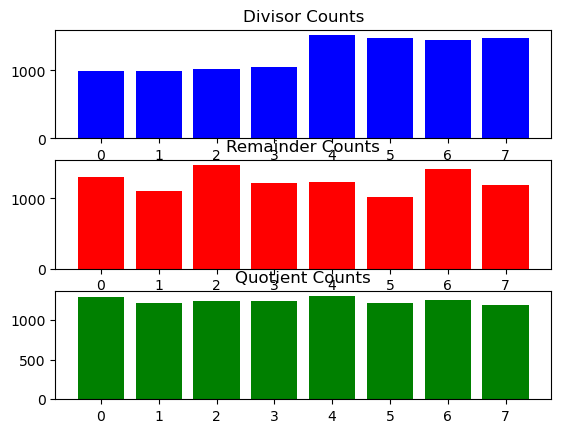

In [134]:
result = draper_job.result()[0]
arr = result.data.c

# M3 Error correction (Uses up too much of my free compute time)
# mappings = m3.utils.final_measurement_mapping(isa_circuit)
# mit = m3.M3Mitigation(backend)
# mit.cals_from_system(mappings)
# quasis = mit.apply_correction(arr, mappings)

divisor_counts = arr.slice_bits(range(3,6)).get_int_counts()
remainder_counts = arr.slice_bits(range(0,3)).get_int_counts()
quotient_counts = arr.slice_bits(range(6,9)).get_int_counts()
# plot the counts with chart tile "counts of values"
fig, ax = plt.subplots(3)
ax[0].bar(divisor_counts.keys(), divisor_counts.values(), color='b')
ax[0].set_title('Divisor Counts')
ax[1].bar(remainder_counts.keys(), remainder_counts.values(), color='r')
ax[1].set_title('Remainder Counts')
ax[2].bar(quotient_counts.keys(), quotient_counts.values(), color='g')
ax[2].set_title('Quotient Counts')

# mode
print("Mode of divisor", max(divisor_counts, key=divisor_counts.get))
print("Mode of remainder", max(remainder_counts, key=remainder_counts.get), f'{max(remainder_counts, key=remainder_counts.get):03b}')
print("Mode of quotient", max(quotient_counts, key=quotient_counts.get))

There is still a general domination of errors in the draper version of the divider. For the quotient we see that roughly all values are approxiametly equal. Interestingly enough for the divisor there is a favoring of having the most significant bit set to 1. Finally for the remainder we have that the remained of 2 is slightly more favored than the others despite this not being the case. 

### Yuan Divider
Orts et al. in their 2024 paper "Quantum circuit optimization of an integer divider" propose a divder with an even further optimized t-count and t-depth which is linear in N the divided bits but still quadratic in M the divisor bits. Furthermore their algorithm is no longer reversible (thus could not be used in an algorithm like grovers) and requires extra ancilla qubits beyond the output. Nevertheless I implemented it anyways and an example of it is shown below for the N=6 M=2 case. Their divider is based on one published by Yuan et al. in 2022 titled "A novel fault-tolerant quantum divider and its simulation". This division algorithm is not directly comparable with that of Thapliyal anyways as its input and output sizes and restraints are different. Nevertheless I thought it would be neat to demonstrate. 

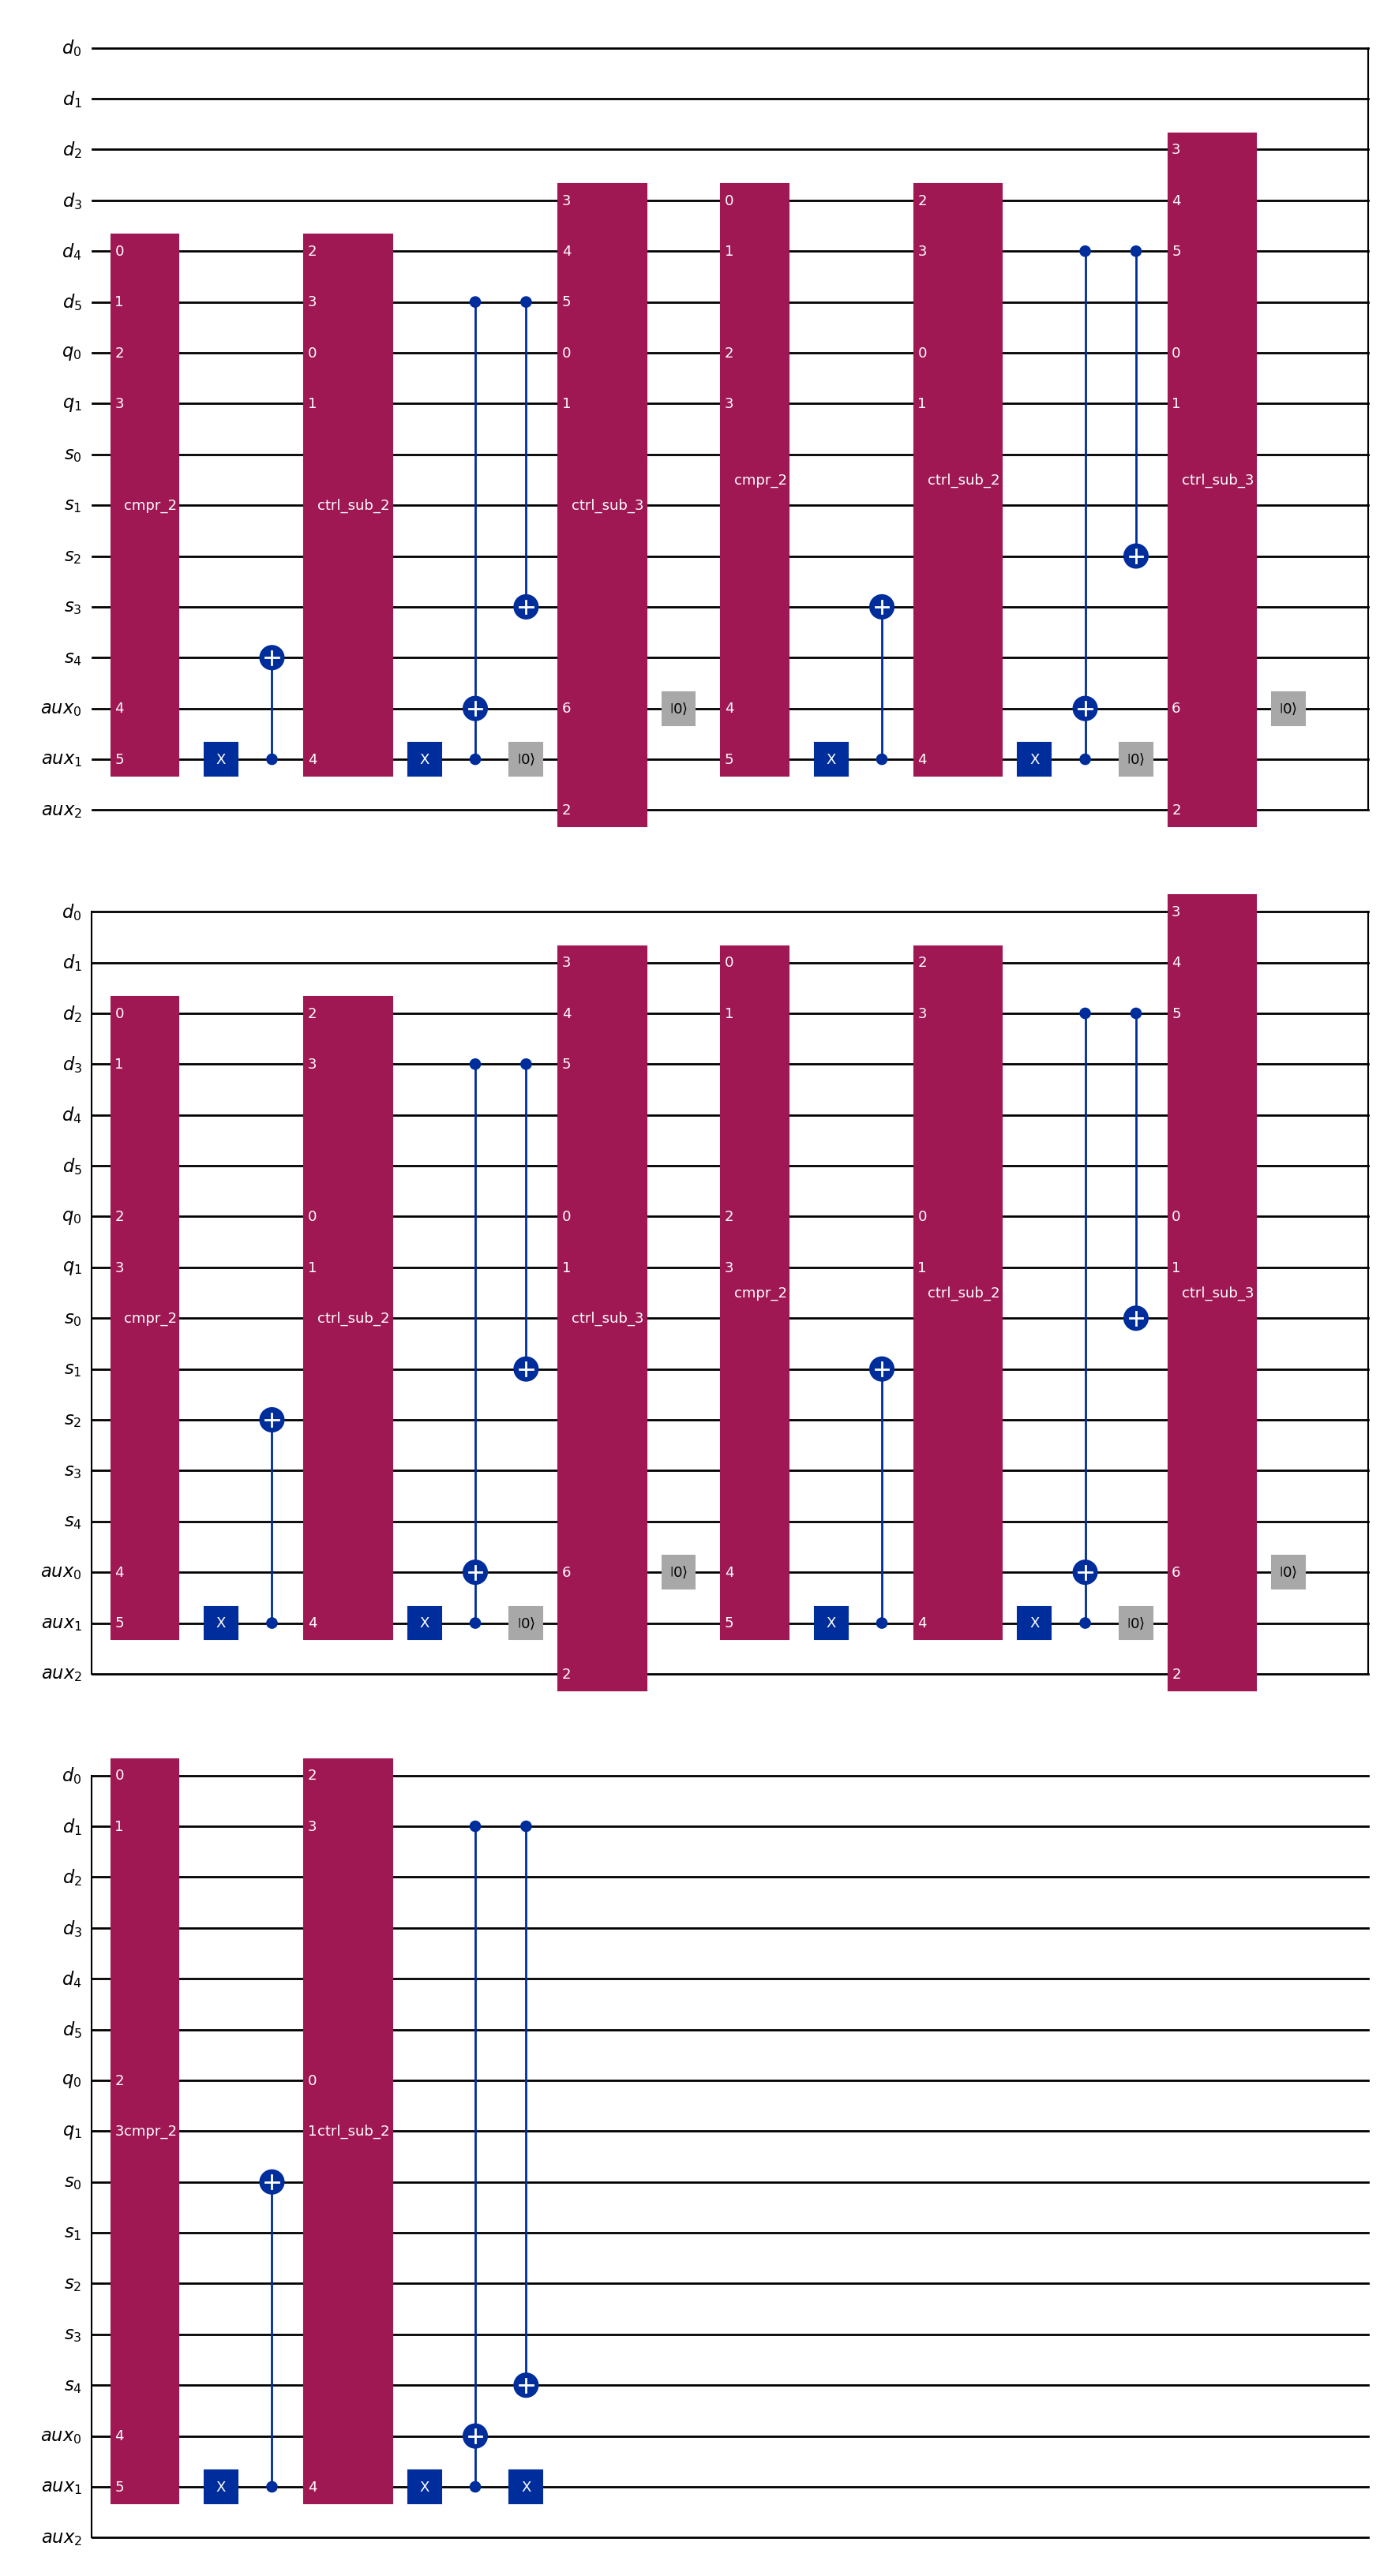

In [99]:
alt_circ = other_divider(6,2) 
alt_circ.draw('mpl')

## Conclusion

Ultimately while I find this algorithm quite interesting it cannot feasibly be run on todays quantum computers without some sort of error correction in order to get a reliable result. This is likely due to the fact that the algorithm is quite long and requires a large number of complex gates to run. That said the algorithm would seem to fit all the important points of a good division algorithm which could easily be used in a larger quantum algorithm since its underlying components can be easily switched out to fit the capabilities of each quantum computer instruction set and other characteristics.

In the future, as quantum computers continue to improve and error correction techniques become more advanced, it is likely that this algorithm and others like it will become more practical and reliable for real-world applications. This work lays the foundation for such advancements and highlights the importance of continued research and development in quantum computing algorithms. Furthermore I think having even simple algorithms like this one for division is important as they facilitate different developments within the field to be chained together so that more practical and important applications may be realized down the line. 